<img src="https://res.cloudinary.com/cognitives-s3/image/upload/c_limit,dpr_auto,f_auto,fl_lossy,q_auto,w_1200/v1/cog-live/n/1271/2020/May/21/cgWhR4ArheoPsIKgoFRl.jpg" width="500px">

# COVID-19 Vaccination Progress - The Big Picture
___

The vaccination campaign started around three months ago already and with so many information in the media, it may be difficult to get the big picture.

This data analysis is focused on summarizing how the COVID-19 vaccination is going around the world. More accurately, it is focused on answering the following questions: 

* How many types of vaccine are used? Where a specific vaccine is used in the world?
* Where are vaccinated more people per day?
* Where is the vaccination program more advanced? When will we have 25% of the population immunized?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
#pip install fbprophet

## 1. Data Preparation
___


### 1.1. Importing and merging the data sources

In [2]:
vaccinations = pd.read_csv('country_vaccinations.csv')
vaccinations.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.00,0.00,nan,nan,nan,0.00,0.00,nan,nan,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,nan,nan,nan,nan,64.00,nan,nan,nan,22.00,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.00,128.00,nan,nan,64.00,0.00,0.00,nan,22.00,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.00,188.00,nan,60.00,63.00,0.01,0.01,nan,22.00,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.00,266.00,nan,78.00,66.00,0.01,0.01,nan,23.00,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...


I will keep only the columns that I think will help me answer my questions.

In [3]:
vaccinations = vaccinations[['date', 
                             'country', 
                             'iso_code', 
                             'daily_vaccinations', 
                             'people_vaccinated_per_hundred',
                             'vaccines',
                            ]]

In addition, I would need continent/region information for each country. But, before joining the data, I will check for categorical missing values:

In [4]:
vaccinations.select_dtypes(include=['object']).isnull().sum()

date          0
country       0
iso_code    272
vaccines      0
dtype: int64

We are missing *iso_code* values for the following countries:

In [5]:
vaccinations.loc[vaccinations.iso_code.isnull(), 'country'].value_counts()

Wales               68
Scotland            68
Northern Ireland    68
England             68
Name: country, dtype: int64

All countries are part of the United Kingdom. Let's fill the missing values with United Kingdom's *iso_code*

In [6]:
vaccinations.loc[vaccinations.country == 'United Kingdom', 'iso_code'].unique()

array(['GBR'], dtype=object)

In [7]:
vaccinations.loc[vaccinations.country.isin(['England', 'Scotland', 'Wales', 'Northern Ireland']), 'iso_code'] = 'GBR'

Now we are ready for the **data enrichment** -> adding *region* and *sub-region* info to be able to analyze data at continent/region level

In [9]:
continents = pd.read_csv('continents2.csv')
continents.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.00,34.00,nan
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.00,154.00,nan
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.00,39.00,nan
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.00,15.00,nan
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.00,61.00,nan


In [10]:
data = vaccinations.merge(continents[['alpha-3', 'region', 'sub-region']],
                          how='left',
                          left_on = 'iso_code',
                          right_on = 'alpha-3',
                         ).drop(columns=['alpha-3'])
data.head()

,date,country,iso_code,daily_vaccinations,people_vaccinated_per_hundred,vaccines,region,sub-region
0,2021-01-10,Albania,ALB,nan,0.00,Pfizer/BioNTech,Europe,Southern Europe
1,2021-01-11,Albania,ALB,64.00,nan,Pfizer/BioNTech,Europe,Southern Europe
2,2021-01-12,Albania,ALB,64.00,0.00,Pfizer/BioNTech,Europe,Southern Europe
3,2021-01-13,Albania,ALB,63.00,0.01,Pfizer/BioNTech,Europe,Southern Europe
4,2021-01-14,Albania,ALB,66.00,0.01,Pfizer/BioNTech,Europe,Southern Europe


Renaming *region* and *sub-region* columns

In [11]:
data.columns = ['date', 'country', 'iso_code', 'daily_vaccinations', 'people_vaccinated_per_hundred', 'vaccines', 
                'continent', 'region']

I would like to split the Americas into North America and South America

In [12]:
data.continent.value_counts()

Europe      2104
Asia         743
Americas     594
Africa       105
Name: continent, dtype: int64

In [13]:
data.loc[data.region == 'Northern America', 'continent'] = 'North America'
data.loc[data.region == 'Latin America and the Caribbean', 'continent'] = 'South America'

### 1.2. Missing values

In [14]:
data.isnull().sum()

date                                0
country                             0
iso_code                            0
daily_vaccinations                135
people_vaccinated_per_hundred    1615
vaccines                            0
continent                           9
region                              9
dtype: int64

We are missing *region / sub-region* for Northern Cyprus

In [15]:
data.loc[data.continent.isnull(), 'iso_code'].value_counts()

OWID_NCY    9
Name: iso_code, dtype: int64

In [16]:
data[data.country.isin(['Cyprus', 'Turkey'])][['continent', 'region']].drop_duplicates()

,continent,region
814,Asia,Western Asia


In [17]:
data.loc[data.country == 'Northern Cyprus', 'continent'] = 'Asia'
data.loc[data.country == 'Northern Cyprus', 'region'] = 'Western Asia'

We are missing *daily_vaccinations* info for 121 records. Let's see for which countries and which dates

In [18]:
data.loc[data.daily_vaccinations.isnull(), 'country'].value_counts()

Latvia            18
Albania            7
Panama             6
Canada             5
Austria            4
                  ..
Indonesia          1
Cayman Islands     1
Belgium            1
Mauritius          1
United Kingdom     1
Name: country, Length: 97, dtype: int64

In [19]:
data.loc[data.daily_vaccinations.isnull(), 'date'].value_counts().head()

2020-12-28    10
2020-12-27     9
2021-01-10     6
2020-12-30     5
2021-01-24     5
Name: date, dtype: int64

The majority is around Christmas and New Year's Eve and the missing values are distributed to all countries; it can be the case that no vaccinations were performed. However, I will choose not to make any assumption and not to fill the missing values for *daily_vaccinations*.

Percentage of missing values for *people_vaccinated_per_hundred*

In [20]:
data.loc[data.people_vaccinated_per_hundred.isnull()].shape[0] / data.shape[0]

0.4542897327707454

Unfortunately, for *people_vaccinated_per_hundred*, we have ~50% values missing.

Let's visualize the missing values percentages per region.

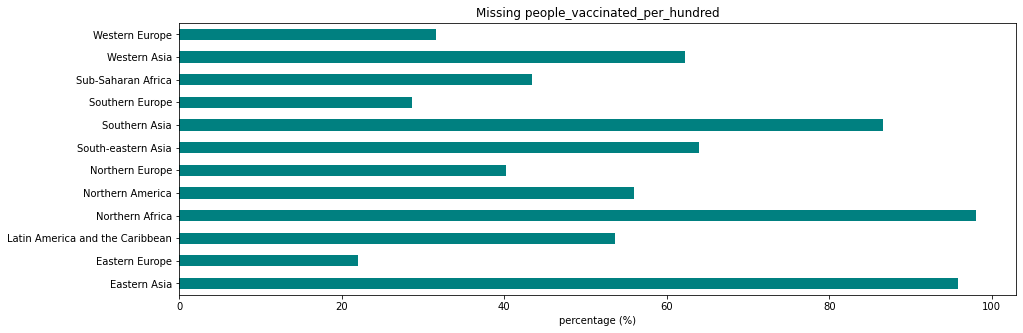

In [22]:
(
    data[data.people_vaccinated_per_hundred.isnull()].region.value_counts() / data.region.value_counts()
).mul(100).plot.barh(color="teal", figsize=(15,5))

plt.title('Missing people_vaccinated_per_hundred')
plt.xlabel('percentage (%)')
plt.show()

*people_vaccinated_per_hundred* represents the ratio (in percent) between population immunized and total population up to the date in the country. Since it contains the cumulative total until that date, I will fill the missing values for each country with the last available value.

In [23]:
data.sort_values(by='date', inplace=True)
all_countries = list(data.country.unique())

for country in all_countries:
    data.loc[data.country == country, 'people_vaccinated_per_hundred'] = \
    data.loc[data.country == country, 'people_vaccinated_per_hundred'].fillna(method='bfill').fillna(method='ffill')

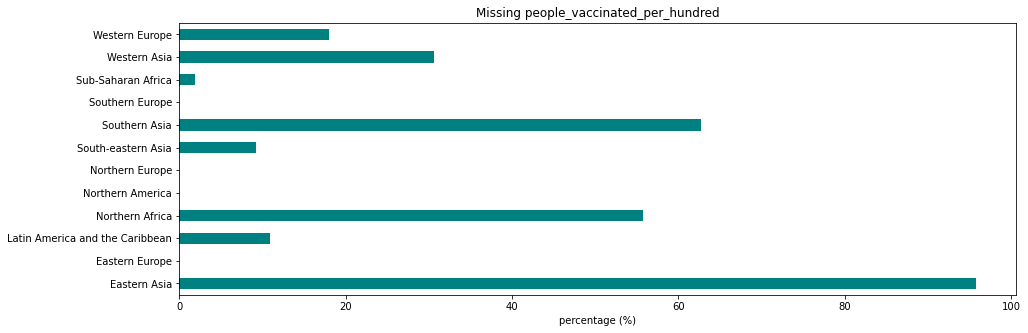

In [24]:
(
    data[data.people_vaccinated_per_hundred.isnull()].region.value_counts() / data.region.value_counts()
).mul(100).plot.barh(color="teal", figsize=(15,5))

plt.title('Missing people_vaccinated_per_hundred')
plt.xlabel('percentage (%)')
plt.show()

Now the remaining countries with missing *people_vaccinated_per_hundred* do not have any value for the variable. Therefore, I will choose to analyze *people_vaccinated_per_hundred* only for Europe and America.

## 2. Data Analysis
___

Note that in our dataset we do not have data available for all countries in the world.

In the map plot below are colored all countries with available data in our dataset. Also, you can visualize which countries belong to each region. 

In [26]:
fig = px.choropleth(locations = data.iso_code, 
                    color = data.region,
                    color_continuous_scale = 'rainbow',
                    title = 'Regions with available data', 
                   )
fig.show()

### 2.1. What vaccines are used around the world?

In order to illustrate where a specific vaccine is used in the world, I will create an interactive plotly map plot, as above.

Since in some countries there is used more than one vaccine, some preprocessing will be needed.

In [27]:
data.vaccines.value_counts()

Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                          1013
Pfizer/BioNTech                                                                        789
Oxford/AstraZeneca, Pfizer/BioNTech                                                    613
Moderna, Pfizer/BioNTech                                                               315
Sputnik V                                                                              158
Oxford/AstraZeneca                                                                     109
Sinovac                                                                                 76
Pfizer/BioNTech, Sinovac                                                                64
Oxford/AstraZeneca, Sinopharm/Beijing                                                   63
Pfizer/BioNTech, Sinopharm/Beijing                                                      59
Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac                                             57

I will start by creating a dataframe with unique *iso_code* - *vaccines* pairs. 

Vaccines is a detail column for each country, so my dataframe will have the number of rows equal to the number of countries in the dataset.

In [28]:
df = data[['iso_code', 'vaccines']].drop_duplicates()
df.shape

(93, 2)

In [29]:
data.iso_code.unique().shape

(93,)

Next, I will create a dataframe to be used for plotting. 

The dataframe will have one record for each country and type of vaccine used. This way, we can get the big picture for each type of vaccine.

In [30]:
#create dataframe with one record for each country and type of vaccine used
map_plot_df = pd.concat([pd.Series(row['iso_code'], row['vaccines'].split(','))              
                         for _, row in df.iterrows()]).reset_index()

#rename columns
map_plot_df.columns = ['vaccine', 'iso_code']

#strip white spaces
map_plot_df['vaccine'] = map_plot_df['vaccine'].str.strip(' ')

map_plot_df.vaccine.value_counts()

Pfizer/BioNTech       63
Oxford/AstraZeneca    45
Moderna               27
Sinopharm/Beijing     11
Sputnik V              9
Sinovac                6
Sinopharm/Wuhan        2
Covaxin                1
Johnson&Johnson        1
Name: vaccine, dtype: int64

<img src="https://cdn.pixabay.com/photo/2016/03/31/19/17/cartoon-1294877_960_720.png" width="25px" style=”float:left;margin:0;”> **Tip**:


You can interact with the map. If you want to see where a specific vaccine is used, you can deselect all the other categories from the legend, and select only one at a time (or you can double click a category).

In [31]:
fig = px.choropleth(locations = map_plot_df.iso_code, 
                    color = map_plot_df.vaccine,
                    color_continuous_scale = 'rainbow',
                    title = 'Where is each vaccine used?', 
                   )
fig.show()

### 2.2. Where are vaccinated more people per day?

**Daily vaccinations** represent the number of doses administrated in a specific day.



Average daily vacinations by country:

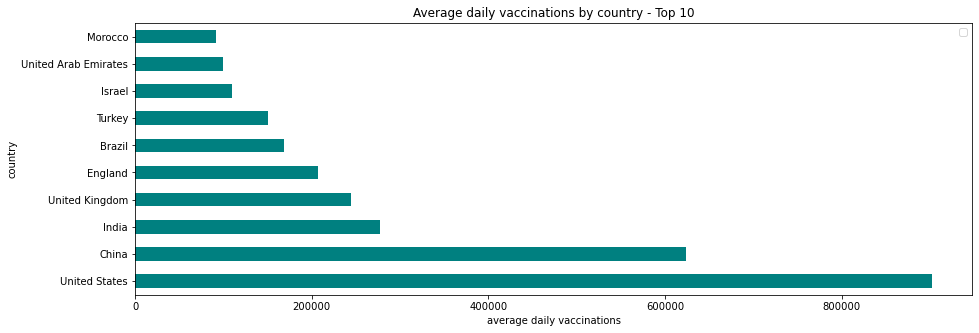

In [32]:
data.groupby(['country']).agg({'daily_vaccinations':'mean'}).sort_values(by='daily_vaccinations', ascending=False)[:10].plot.barh(color="teal", figsize=(15,5))
plt.title('Average daily vaccinations by country - Top 10')
plt.legend('')
plt.xlabel('average daily vaccinations')
plt.show()

In order to illustrate the evolution of daily vaccinations, I will create interactive Plotly line plots using the function below (more details in its definition).

In [33]:
def plot_daily_vaccination_data(data, region_column, regions_list, vaccination_metric, plot_title, min_date = '2020-12-13', max_date='2021-02-13'):
    '''
    Plots a vaccination metric using Plotly library
    
    INPUT 
        data : Pandas dataframe
            a dataframe holding the data to be plotted 
            must contain a date column (unique dates), a region column and a vaccination related metric
        region_column : string
            name of the region column 
            (continent/region/country)
        regions_list : list
            list of strings with regions to be plotted
            must contain values of region_column
        vaccination_metric : string
            name of the vaccination metric column 
            (daily_vaccinations/people_fully_vaccinated_per_hundred)
        plot_title : string 
            the title of your plot
        min_date : string
            lower date limit for the plot
        max_date : string
            upper date limit for the plot
    '''
    df = data[(data[region_column].isin(regions_list)) & (data.date <= max_date) & (data.date >= min_date)]
    fig = px.line(df, 
                  x = 'date', 
                  y = vaccination_metric,
                  color = region_column,
                  title = plot_title
                 )
    fig.show()

Preparing data for the plots -> aggregating at date and continent/region level

In [34]:
continents_daily_df = data.groupby(['date', 'continent']).agg({'daily_vaccinations':'sum',
                                                               'people_vaccinated_per_hundred':'mean',
                                                              }).reset_index()
regions_daily_df = data.groupby(['date', 'region']).agg({'daily_vaccinations':'sum',
                                                         'people_vaccinated_per_hundred':'mean',
                                                        }).reset_index()

In [35]:
all_continents = list(continents_daily_df.continent.unique())
all_regions = list(regions_daily_df.region.unique())

In [37]:
plot_daily_vaccination_data(data = continents_daily_df,  
                            region_column = 'continent',
                            regions_list = all_continents,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Continent in the first three months',
                            min_date = '2020-12-13',
                            max_date = '2021-02-13'
                           )

In [38]:
print('Maximum vaccinations in a day in a country - summary per continent: \n====================================================================')
for continent in all_continents:
    df = data[data.continent == continent].sort_values(by=['daily_vaccinations'], ascending=False).iloc[0]
    print(f'\t{df.continent} -> {round(int(df.daily_vaccinations)/1000000,2)} million vaccinations in {df.country} on {df.date}')

Maximum vaccinations in a day in a country - summary per continent: 
	Europe -> 0.45 million vaccinations in United Kingdom on 2021-02-12
	Asia -> 1.92 million vaccinations in China on 2021-02-07
	North America -> 1.72 million vaccinations in United States on 2021-02-16
	South America -> 0.26 million vaccinations in Brazil on 2021-02-19
	Africa -> 0.2 million vaccinations in Morocco on 2021-02-18


In [39]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = all_regions,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Region',
                            min_date = '2020-12-13',
                            max_date = '2021-02-13'
                           )

In [40]:
print('Maximum vaccinations in a country in a day - summary per region: \n================================================================')
for region in all_regions:
    df = data[data.region == region].sort_values(by=['daily_vaccinations'], ascending=False).iloc[0]
    print(f'\t{df.region} -> {round(int(df.daily_vaccinations)/1000000,4)} million vaccinations in {df.country} on {df.date}')

Maximum vaccinations in a country in a day - summary per region: 
	Northern Europe -> 0.4452 million vaccinations in United Kingdom on 2021-02-12
	Eastern Asia -> 1.9162 million vaccinations in China on 2021-02-07
	Eastern Europe -> 0.1036 million vaccinations in Russia on 2021-02-01
	Northern America -> 1.7163 million vaccinations in United States on 2021-02-16
	Western Asia -> 0.4356 million vaccinations in Turkey on 2021-02-18
	Latin America and the Caribbean -> 0.2627 million vaccinations in Brazil on 2021-02-19
	Southern Europe -> 0.1385 million vaccinations in Serbia on 2021-02-19
	Western Europe -> 0.1255 million vaccinations in Germany on 2021-02-16
	Sub-Saharan Africa -> 0.0024 million vaccinations in Seychelles on 2021-02-13
	South-eastern Asia -> 0.0847 million vaccinations in Indonesia on 2021-02-15
	Southern Asia -> 0.3925 million vaccinations in India on 2021-02-19
	Northern Africa -> 0.1968 million vaccinations in Morocco on 2021-02-18


<img src="https://cdn.pixabay.com/photo/2016/03/31/19/17/cartoon-1294877_960_720.png" width="25px" style=”float:left;margin:0;”> **Tip**:


You can interact with the plot. You can visualize the progress by region in a specific continent by selecting the regions from the legend. Alternatively, only the regions of interest can be plotted.

In [41]:
Europe = ['Northern Europe', 'Eastern Europe', 'Western Europe', 'Southern Europe']
Asia = ['Eastern Asia', 'Western Asia', 'South-eastern Asia', 'Southern Asia']
Africa = ['Sub-Saharan Africa', 'Northern Africa']
Americas = ['Northern America', 'Latin America and the Caribbean']

In [42]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = Europe,
                            vaccination_metric = 'daily_vaccinations',
                            plot_title = 'Daily COVID-19 Vaccinations - Summary per Region in Europe'
                           )

### 2.3. Where is the vaccination program more advanced?

___

We've seen where are vaccinated more people per day, but in terms of total people vaccinated per hundred, how is it going?

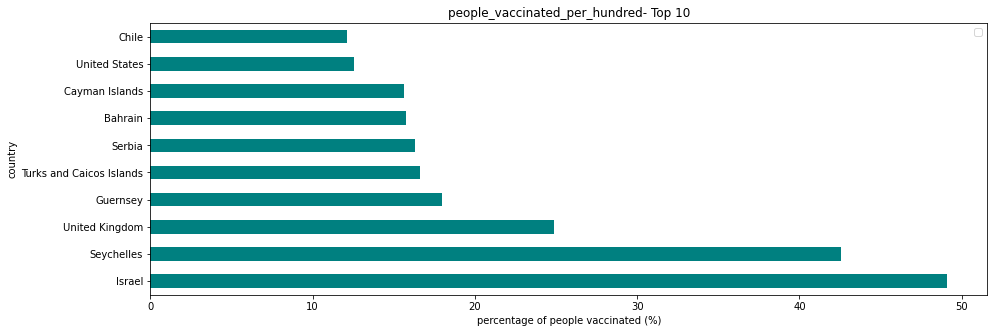

In [43]:
uk_countries = ['England', 'Scotland', 'Wales', 'Northern Ireland', 'Jersey', 'Isle of Man', 'Bermuda', 'Gibraltar']
data[~data.country.isin(uk_countries)].groupby(['country']).agg({'people_vaccinated_per_hundred':'max'}).sort_values(by='people_vaccinated_per_hundred', ascending=False)[:10].plot.barh(color="teal", figsize=(15,5))
plt.title('people_vaccinated_per_hundred- Top 10')
plt.legend('')
plt.xlabel('percentage of people vaccinated (%)')
plt.show()

When it comes to the percentage of people vaccinated, after three months Israel is the leader, followed by Seychelles(that has only ~98k inhabitants) and then by the United Kingdom.

Below there is the progress of *people_vaccinated_per_houndred* only on Europe and North America, because of the missing data in other continents.

In [44]:
plot_daily_vaccination_data(data = regions_daily_df,  
                            region_column = 'region',
                            regions_list = Europe + ['Northern America'],
                            vaccination_metric = 'people_vaccinated_per_hundred',
                            plot_title = 'people_vaccinated_per_hundred evolution in the first three months',
                           )

**Analysis per country: when will we have 25% of population vaccinated?**

To answer This question, I will make timeseries predictions using [Facebook's Prophet](https://facebook.github.io/prophet/).

In [ ]:
def fbprophet_predict_and_plot(data, region_column, region, vaccination_metric, min_date = '2020-12-13', max_date='2021-02-13', future_days=10, plot=True):
    '''
    Plots or returns FbProphet predictions for a vaccination metric

    INPUT 
    data : Pandas dataframe
        a dataframe holding the data to be used for training and plotting 
        must contain a date column (unique dates), a region column and a vaccination related metric
    region_column : string
        name of the region column (continent/region/country)
    region : string
        region of interest - the region to get predictions and plots for
        must be a value of region_column
    vaccination_metric : string
        name of the vaccination metric column (daily_vaccinations/people_fully_vaccinated_per_hundred)
    min_date : string
        lower date limit for the training data
    max_date : string
        upper date limit for the training data
    future_days : integer
        number of days to forecast
    plot : boolean
        whether you want a plot or the forecast
    '''
    df = data[(data[region_column] == region) & (data.date <= max_date) & (data.date >= min_date)]
    df = df[['date', vaccination_metric]]
    df.columns = ['ds', 'y']
    model = Prophet(interval_width = 0.95)
    model.fit(df)
    future = model.make_future_dataframe(periods=future_days)
    forecast = model.predict(future)
    if plot:
        fig = plot_plotly(model, forecast)
        fig.show()
    else:
        return forecast

United States may have 25% of the population vaccinated by April 5, according to the predictions below

In [ ]:
fbprophet_predict_and_plot(data = data, 
                           region_column = 'country',
                           region = 'United States',
                           vaccination_metric = 'people_vaccinated_per_hundred',
                           future_days = 55,
                          )

Next, I will use the defined function to make similar predictions for countries in Europe and North America that have values for *people_vaccinated_per_hundred*

In [ ]:
#all countries in Europe and United States
all_countries_EU_US = list(data[data.continent.isin(['Europe', 'North America'])].country.unique())
#removing countries from UK
all_countries_EU_US = [country for country in all_countries_EU_US if country not in uk_countries]

In [ ]:
names = []
dates = []

In [ ]:
for country in all_countries_EU_US:
    
    #if there are no people_vaccinated_per_hundred values for country, skip country
    if data[(data['people_vaccinated_per_hundred'].notnull()) & (data['country'] == country)].shape[0] > 2:
    
        min_date = data[(data['country'] == country)].date.min()

        forecast = fbprophet_predict_and_plot(data = data, 
                                              region_column = 'country',
                                              region = country,
                                              vaccination_metric = 'people_vaccinated_per_hundred',
                                              min_date = min_date,
                                              future_days = 300,
                                              plot = False,
                                             )

        if not forecast.loc[forecast.yhat > 25].empty:
            names.append(country)
            dates.append(forecast.loc[forecast.yhat > 25].ds.min().date())

Timeline based on the predictions

In [ ]:
#the code below is taken from https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(25, 7), constrained_layout=True)
ax.set(title="When can we have 25% of people vaccinated?")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
vert[13] = 'top' #addded cheat - might fix later
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

Where will we be when summer starts?

Below there are predictions of the percentage of people vaccinated per country, until June:

In [ ]:
print('Predicted percentage of people vaccinated until June: \n======================================================')

for country in all_countries_EU_US:
    
    #if there are no people_vaccinated_per_hundred values for country, skip country
    if data[(data['people_vaccinated_per_hundred'].notnull()) & (data['country'] == country)].shape[0] > 2:
    
        min_date = data[(data['country'] == country)].date.min()

        forecast = fbprophet_predict_and_plot(data = data, 
                                              region_column = 'country',
                                              region = country,
                                              vaccination_metric = 'people_vaccinated_per_hundred',
                                              min_date = min_date,
                                              future_days = 150,
                                              plot = False,
                                             )
    
        #print predicted percentage of vaccinated people until June
        print('\t', country, '\t', round(float(forecast.loc[forecast.ds == '2021-06-01'].yhat),2), '%')

... until then ...

<img src="https://worldfinancialreview.com/wp-content/uploads/2020/06/virus-1.jpg" width="500px">

The world is doing a great job bringing this pandemic to an end and the medical progress is impressive. However, we noticed that it is a real challenge to make the vaccines available all over the globe and that there is a difference between the progress in each continent.

According to the predictions in this notebook, a lot of countries would reach the 25% of population vaccinated threshold only at the end of this year or even in 2022. This won’t be ideal, but maybe in the near future we will witness day by day improvements when it comes to the availability of the vaccine and the number of people vaccinated in a day. Also, the fact that more types of vaccines are tested, accepted and used in the world can strengthen our hope to go back to a normal life.

Until then, take care, don’t forget to wear a mask and hold on, because the end of this pandemic may be closer than we imagine. I hope the notebook was insightful, and as I am new to Kaggle, I would really appreciate some feedback. :)